In [11]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.optimize import minimize
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
from utilites import preprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, check_random_state
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
import time
from tqdm import tqdm
from math import sqrt
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from own_forest import *
from sklearn.base import clone

In [3]:
max_int_val = np.iinfo(np.int32).max

## Алгоритм бэггинга над бустингом эл.кл.

In [4]:
def _generate_bagging_indices(rng, n_samples, sample_fraction, bootstrap):
    """Generates bootstrap indices for bagging."""
    if bootstrap:
        indices = rng.choice(n_samples, size=int(n_samples*sample_fraction), replace=True)
    else:
        indices = rng.choice(n_samples, size=int(n_samples*sample_fraction), replace=False)
    return indices

In [5]:
class BaggingElementaryTrees(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        print(self.base_estimator)
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = np.random.RandomState(self.random_state)
        seeds = self.random_state_.randint(np.iinfo(np.int32).max, size=self.n_estimators)

        self.estimators_ = []
        self.estimators_features_ = []

        if self.n_jobs is None:
            for seed in seeds:
                estimator, features = self._fit_estimator(X, y, seed)
                self.estimators_.append(estimator)
                self.estimators_features_.append(features)
        else:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_estimator)(X, y, seed) for seed in seeds)
            self.estimators_, self.estimators_features_ = zip(*results)

        return self

    def _fit_estimator(self, X, y, seed):
        rng = np.random.default_rng(seed)
        samples = _generate_bagging_indices(rng, X.shape[0], self.sub_sample_size, self.bootstrap)
        if self.bootstrap_features:
            features = _generate_bagging_indices(rng, X.shape[1], self.sub_feature_size, self.bootstrap)
        else:
            features = np.arange(X.shape[1])

        estimator = self.base_estimator.__class__(num_iter=11, m=40)
        estimator.fit(X[samples][:, features], y[samples])
        
        return estimator, features

    def predict(self, X):
        # Соберите предсказания от всех деревьев
        predictions = np.mean([est.predict(X[:, features]) for est, features in zip(self.estimators_, self.estimators_features_)], axis=0)
        return predictions

In [11]:
class BaggingElementaryTrees(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0,
                 bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        # Использование Double Underscore для правильной инициализации
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = check_random_state(self.random_state)
        
        # Инициализация генератора случайных чисел с использованием random_state_ если необходимо
        n_samples, self.n_features_ = X.shape
        self.features_indices_ = []
        
        # Создание и параллельное обучение базовых оценщиков
        self.estimators_ = Parallel(n_jobs=self.n_jobs)(
            delayed(self._fit_estimator)(X, y, self.random_state_.randint(np.iinfo(np.int32).max))
            for i in range(self.n_estimators)
        )
        
        return self

    def _fit_estimator(self, X, y, random_state):
        rng = np.random.default_rng(random_state)
        n_samples = X.shape[0]
        sample_size = int(self.sub_sample_size * n_samples)
        feature_size = int(self.sub_feature_size * self.n_features_)
        
        # Выбор подмножеств признаков и объектов с использованием бутстрапа или без него.
        if self.bootstrap:
            indices = rng.choice(n_samples, size=sample_size)
        else:
            indices = rng.permutation(n_samples)[:sample_size]
            
        if self.bootstrap_features:
            features_indices = rng.choice(self.n_features_, size=feature_size, replace=False)
        else:
            features_indices = rng.permutation(self.n_features_)[:feature_size]
        
        self.features_indices_.append(features_indices)
        
        # Создание экземпляра базового оценщика с его последующей инициализацией
        estimator = clone(self.base_estimator)
        estimator.fit(X[indices][:, features_indices], y[indices])
        
        return estimator

    def predict(self, X):
        # Сбор предсказаний от всех обученных оценщиков
        predictions = np.mean([est.predict(X[:, self.features_indices_[i]]) for i, est in enumerate(self.estimators_)], axis=0)
        return predictions

## Подготовка данных

In [7]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [8]:
dataset.shape

(398, 8)

In [35]:
# y = dataset['MPG'].to_numpy()
# X = dataset.drop(columns='MPG')

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train, X_test, y_train, y_test = preprocess(dataset, 'MPG')

In [2]:
# diabetes = load_diabetes()
# X, y = diabetes.data, diabetes.target
# df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
# df['TARGET'] = diabetes.target

# X_train, X_test, y_train, y_test = preprocess(df)

## Обучение и подбор параметров бустинга

In [6]:
lb_params =  {
    "m" : np.linspace(5, 50, 10).astype(int),
    "num_iter" : np.linspace(10, 50, 20).astype(int),
    "max_cov": [500]
}

models = [BoostingElementaryPredicates()]

params = [lb_params]

In [8]:
results = []
time_results = []

In [19]:
for model, param in tqdm(zip(models, params)):
    start_time = time.time()
    grid = GridSearchCV(model, param, cv=5, scoring='neg_mean_squared_error')
    grid.fit(X_train, y_train)
    
    scores = cross_val_score(grid.best_estimator_, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse = np.abs(np.mean(scores))
    r2 = r2_score(y_test, grid.predict(X_test))
   
    results.append(f"{model.__class__.__name__}:\nBest params:{grid.best_params_}\nMSE: {mse:.2f}\nR2: {r2:.2f}\n")
    end_time = time.time()
    time_results.append({'model': model.__class__.__name__, 'time': end_time - start_time})

print('Results:')
for res in results:
    print(res)

print('\nTime results:')
for tres in time_results:
    print(tres)

NameError: name 'models' is not defined

В предыдущей ячейке есть недочеты с подбором параметров (см. ниже графики)

11


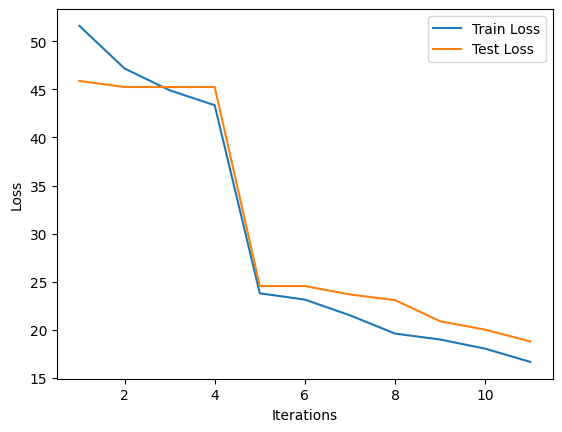

BoostingElementaryPredicates:
Mean Squared Error: 4.3362940399670515
R2 Score: 0.6502754378086654


In [10]:
model = BoostingElementaryPredicates1(num_iter=11, m=59) # критическое значение
model.fit_predict(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_test)
print("BoostingElementaryPredicates:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

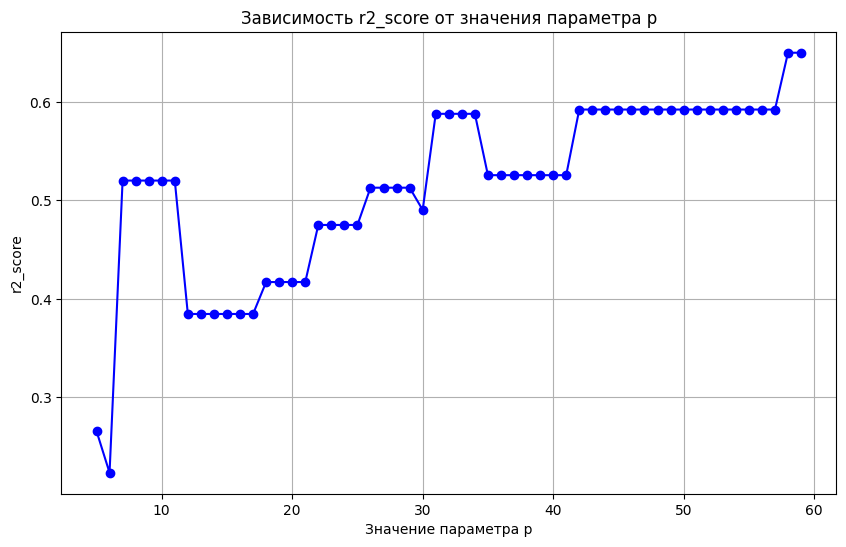

In [11]:
m_values = list(range(5, 60, 1)) # Равномерная сетка от 5 до 59
r2_scores = []

for m in m_values:
    model = BoostingElementaryPredicates(num_iter=11, m=m)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(m_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость r2_score от значения параметра p')
plt.xlabel('Значение параметра p')
plt.ylabel('r2_score')
plt.grid(True)
plt.show()

Увеличение размерности матрицы сравнения позволяет достичь лучшего качества.

TODO: пофиксить краш ядра JupyterNotebook при матрицах размера >= 60 и посмотреть на распределение весов estimators.

## Обучение и подбор параметров бэггинга

In [10]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

# Initializing and training the model
model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=59), n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, n_jobs=40)
rmse, r2_score = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=1.0, num_bags=10, num_iter=10, m=20)

print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2_score}")

BoostingElementaryPredicates(m=59, num_iter=11)


Validation RMSE: 3.7926254358907094
Validation R2: 0.7313740238042155


In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5)

In [7]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [8]:
n_estimators_list = [10, 15, 20, 25]  # Список значений для перебора
rmse_values = []  # Сюда будем сохранять значения RMSE

for n_estimators in n_estimators_list:
    model = BaggingElementaryTrees(base_estimator=BoostingElementaryPredicates(num_iter=11, m=40),
                                   n_estimators=n_estimators,
                                   sub_sample_size=1.0,
                                   sub_feature_size=1.0,
                                   n_jobs=-1,  # Используйте все доступные ядра
                                   random_state=42)
    
    # Обучим модель и рассчитаем RMSE. Пример функции train_and_validate:
    # rmse = train_and_validate(model, X_train, y_train, X_val, y_val)
    # Для примера, давайте просто инициализируем модель и запустим fit-predict.
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    current_rmse = rmse(y_val, predictions)
    
    rmse_values.append(current_rmse)
    print(f"n_estimators: {n_estimators}, RMSE: {current_rmse}")

# Построим график RMSE в зависимости от количества деревьев
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, rmse_values, marker='o', linestyle='-')
plt.title('Зависимость RMSE от числа деревьев в бэггинге')
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

BoostingElementaryPredicates(m=40, num_iter=11)


n_estimators: 10, RMSE: 3.722367952660742
BoostingElementaryPredicates(m=40, num_iter=11)
n_estimators: 15, RMSE: 3.9970967007447826
BoostingElementaryPredicates(m=40, num_iter=11)
n_estimators: 20, RMSE: 3.6806334233657796
BoostingElementaryPredicates(m=40, num_iter=11)


: 

: 

: 

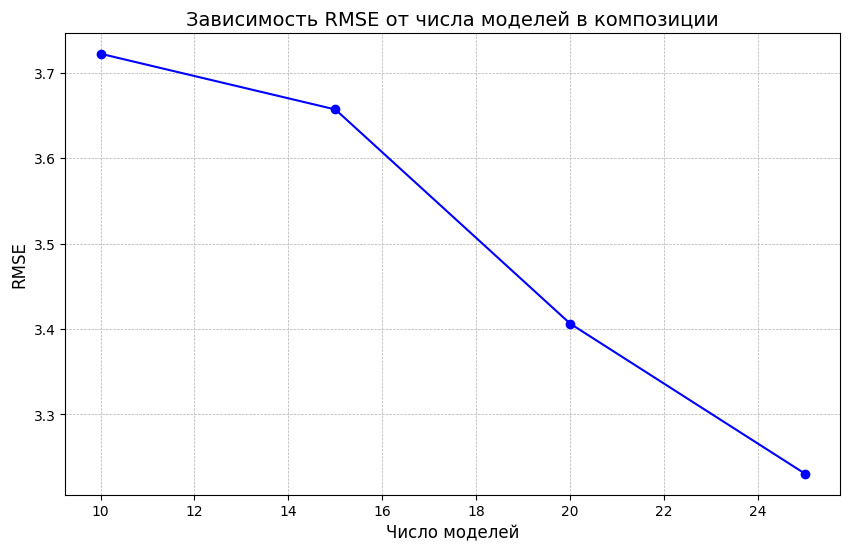

In [8]:
n_estimators = [10, 15, 20, 25]
RMSE = [3.722367952660742, 3.6570967007447826, 3.406334233657796, 3.2306334233657796]

# Создаем график
plt.figure(figsize=(10, 6)) # Размеры графика
plt.plot(n_estimators, RMSE, marker='o', linestyle='-', color='b') # Параметры линии

# Настройка названий и меток
plt.title('Зависимость RMSE от числа моделей в композиции', fontsize=14)
plt.xlabel('Число моделей', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

# Отображаем сетку для лучшей читаемости
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Показываем график
plt.show()

TODO: пофиксить обучение отдельного estimator'а бэггинга.

##  Эксперименты с различными долями признаков

In [36]:
# fractions = np.linspace(0.55, 1, 4)

# results = []

# for fraction in fractions:
#     rmse = train_and_validate(X_train, y_train, X_val, y_val, fraction, num_bags=10, num_iter=100, m=3)  # Пример параметров
#     results.append({'Fraction': fraction, 'RMSE': rmse})

In [ ]:
fracs = np.linspace(0.1, 1.0, 10)  # Диапазон долей признаков
rmses = []  # Список для хранения результатов

for frac in fracs:
    model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=59), n_estimators=10, sub_feature_size=frac, bootstrap=True, bootstrap_features=True, n_jobs=40, random_state=42)
    rmse = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=frac, num_bags=10, num_iter=10, m=20)
    rmses.append(rmse)

# Отрисовка графиков
plt.figure(figsize=(10, 6))
plt.plot(fracs, rmses, marker='o', linestyle='-', color='b')
plt.title('Зависимость RMSE от доли признаков')
plt.xlabel('Доля признаков')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

: 

: 

: 